Working with quality filters
# <span style="color:red">NOTE! This notebook does not work yet since the work with the quality filter was paused. DO NOT CHANGE</span>

In [1]:
import openeo
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from config import user,passwd,eo_service_url
from demo_helpers import show_result
from demo_regions import s2

In [2]:
#eo_service_url = 'http://localhost:8000'
conn = openeo.connect(eo_service_url)
conn.authenticate_basic(username=user, password=passwd)
#conn.authenticate_oidc()

<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

In [3]:
res = conn.list_processes()
[p['id'] for p in res][-10:]

['tan',
 'tanh',
 'variance',
 'xor',
 'filter_quality',
 'bitwise_and',
 'bitwise_or',
 'bitwise_xor',
 'bitwise_left_shift',
 'bitwise_right_shift']

In [8]:
# Load S2MSI2A data
cube = conn.load_collection(
    s2.s2_msi_l2a,
    bands=["b01"],
    spatial_extent=s2.bbox.karlstad_mini_land,
    temporal_extent=["2020-03-01", "2020-08-01"],
    #max_cloud_cover=50, TODO this should work, need to fix
)
args_course = {'data':cube,'filter':'sentinel2-scl-quality-coarse','threshold':0.8}

coarsely_filtered_cube = cube.process(process_id='filter_quality', arguments=args_course)
args_fine = {'data':coarsely_filtered_cube,'filter':'sentinel2-scl-quality-fine','threshold':0.99}
good_data_cube = coarsely_filtered_cube.process(process_id='filter_quality', arguments=args_fine)


display(coarsely_filtered_cube)

In [9]:
good_data_cube.flat_graph()

{'loadcollection1': {'process_id': 'load_collection',
  'arguments': {'bands': ['b01'],
   'id': 's2_msi_l2a',
   'spatial_extent': {'west': 13.460930954751282,
    'east': 13.585449709728213,
    'south': 59.36327761288911,
    'north': 59.40107161575003},
   'temporal_extent': ['2020-03-01', '2020-08-01']}},
 'filterquality1': {'process_id': 'filter_quality',
  'arguments': {'data': {'from_node': 'loadcollection1'},
   'filter': 'sentinel2-scl-quality-coarse',
   'threshold': 0.8}},
 'filterquality2': {'process_id': 'filter_quality',
  'arguments': {'data': {'from_node': 'filterquality1'},
   'filter': 'sentinel2-scl-quality-fine',
   'threshold': 0.99},
  'result': True}}

In [10]:
good_data_cube.execute()


OpenEoApiError: [500] Internal: Server error: Syncronouns job failed with stdout=[Executing process graph: ]stderr=[Job 99d91c5c-988f-4caa-9bd4-8938e0726b33 Synchronous Job job got an Exception <class 'ValueError'>  The truth value of an array with more than one element is ambiguous. Use a.any() or a.all(). Traceback (most recent call last):   File "/opt/conda/lib/python3.10/site-packages/openeo_pg_parser_networkx/graph.py", line 402, in node_callable     return results_cache.__getitem__(node) KeyError: 'filterquality1-9ecec5c4-878a-4065-994a-2e31e897f6fb'  During handling of the above exception, another exception occurred:  Traceback (most recent call last):   File "/proj/src/openeo_des_worker/worker/dask_executor.py", line 142, in execute_job     run_syncronously(pg_text=batch_job.process)   File "/proj/src/openeo_des_worker/worker/dask_executor.py", line 104, in run_syncronously     res = callable_graph()   File "/opt/conda/lib/python3.10/site-packages/openeo_pg_parser_networkx/graph.py", line 379, in node_callable     func(*args, named_parameters=named_parameters, **kwargs)   File "/opt/conda/lib/python3.10/site-packages/openeo_pg_parser_networkx/graph.py", line 415, in node_callable     result = prebaked_process_impl(   File "/opt/conda/lib/python3.10/site-packages/openeo_processes_dask/process_implementations/core.py", line 90, in wrapper     return f(*resolved_args, **resolved_kwargs)   File "/proj/src/openeo_des_worker/processes/filter_quality.py", line 30, in filter_quality     if not data:   File "/opt/conda/lib/python3.10/site-packages/xarray/core/common.py", line 153, in __bool__     return bool(self.values) ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all() ] (ref: 99d91c5c-988f-4caa-9bd4-8938e0726b33)

In [6]:
# Get the b11 band, apply the masks, and calculate the median over the polygon
from openeo.processes import merge_cubes
b11 = cube.band("b11")
b11 = b11.mask(scl_mask)
b11 = b11.mask(nmd_mask)
median_agg = b11.aggregate_spatial(geometries = polygon, reducer = "median")
median_agg

In [7]:
%time res = median_agg.execute()

CPU times: user 5.52 ms, sys: 2.03 ms, total: 7.55 ms
Wall time: 30.4 s


In [8]:
#res # Uncomment this line to show the (rather large dict)

In [9]:
# Unpack the response
medians = np.array(res["data_vars"]["values"]["data"][0])
times = np.array(res["coordinates"]["t"])

In [10]:
# Create None filter
valid_idxs = np.where(medians != None)[0]

In [11]:
# TODO (this worked with old backend): Create cloud filter 
#n_values = np.array([timestep["properties"]["values_total_count"] for timestep in res["features"]])
#valid_idxs2 = np.where(n_values > (np.max(n_values) * .98))[0]

In [12]:
# TODO this is a workaround for the above 
%time pixel_count = (~scl_mask).aggregate_spatial(geometries = polygon, reducer = "sum").execute()
number_of_usable_pixels = pixel_count["data_vars"]["values"]["data"][0]
max_number_of_usable_pixels = np.max(number_of_usable_pixels)
valid_idxs2 = np.where(np.array(number_of_usable_pixels) > max_number_of_usable_pixels * .98)[0]

CPU times: user 5.24 ms, sys: 1.96 ms, total: 7.2 ms
Wall time: 25.7 s


In [13]:
# Merge None and cloud filters
valid_idx_intersection = set(valid_idxs).intersection(valid_idxs2)
valid_idx_intersection = list(valid_idx_intersection)
valid_idx_intersection.sort()


# Apply filter
medians = medians[valid_idx_intersection]
times = times[valid_idx_intersection]
times = [datetime.fromtimestamp(timestamp/1e9) for timestamp in times]


print(f"Number of valid observations: {len(valid_idx_intersection)}")

Number of valid observations: 20


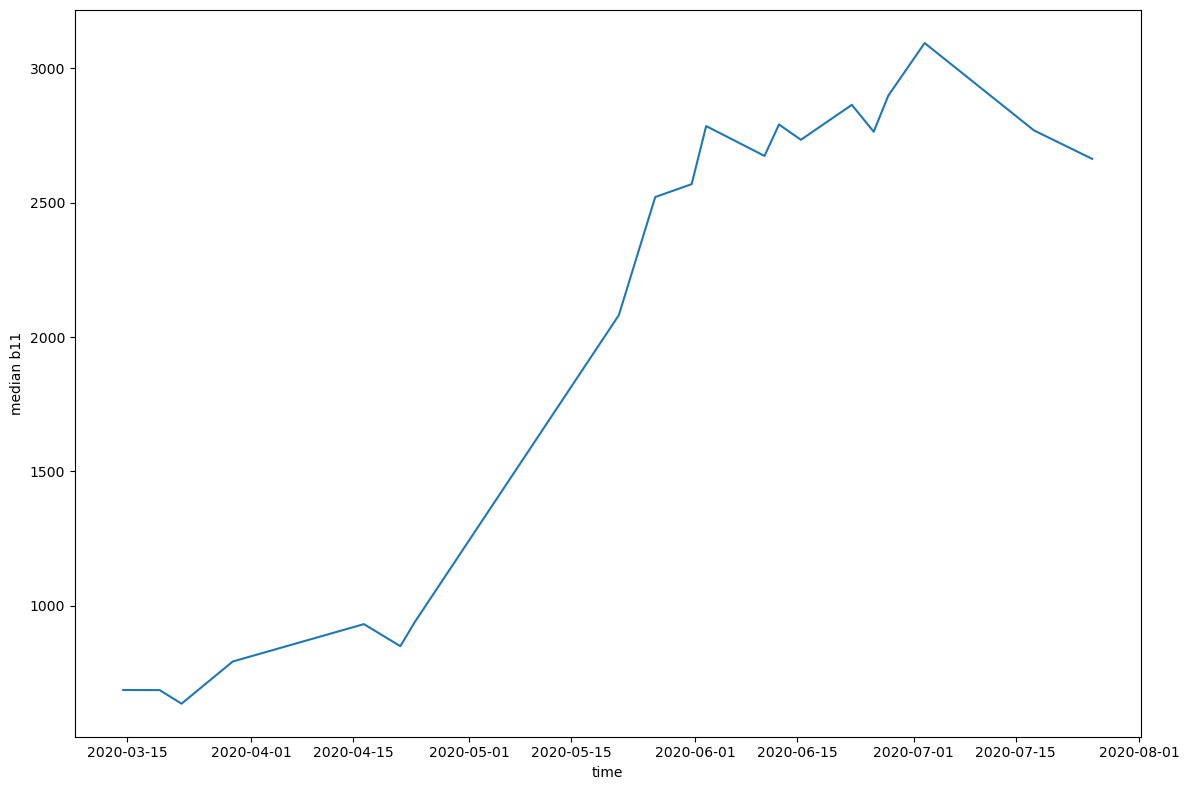

In [14]:
# Plot values
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(times, medians)
plt.ylabel("median b11")
plt.xlabel("time")
plt.tight_layout()
plt.savefig("median_b11.png", dpi=100, pad_inches=0)

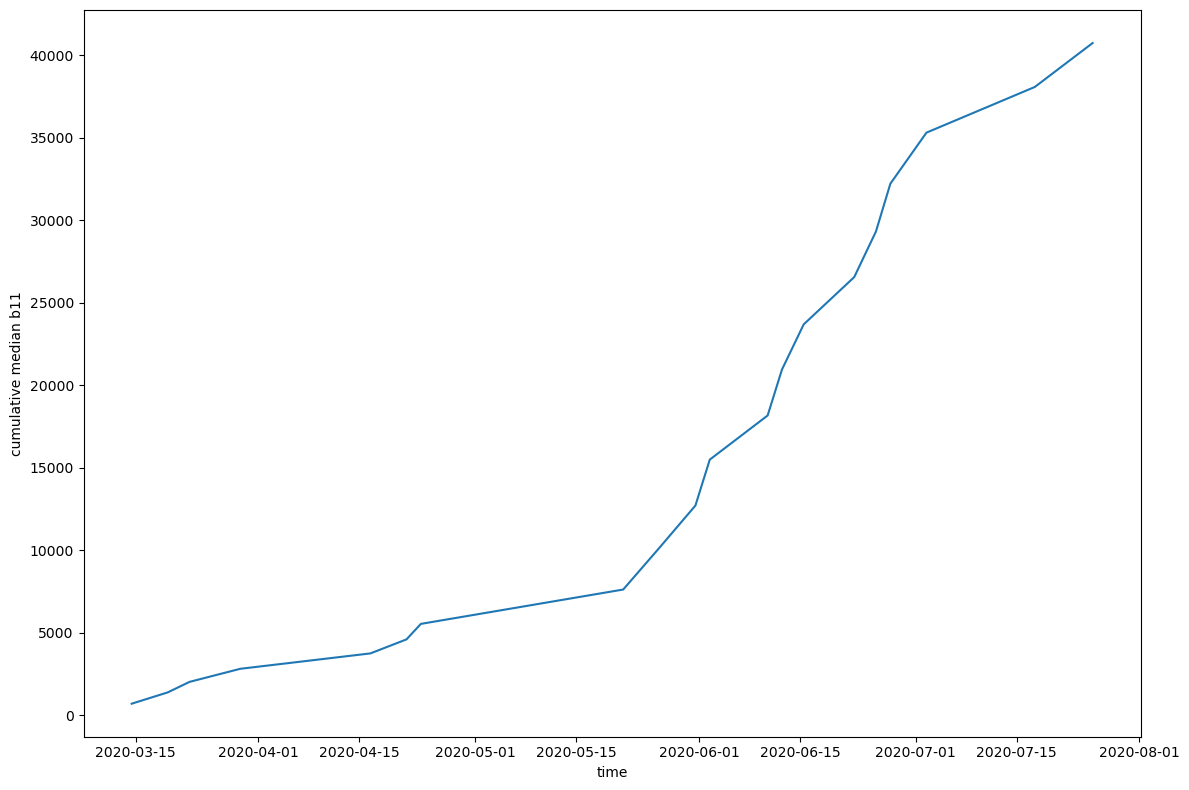

In [15]:
# Plot cumulative sum
plt.plot(times, np.cumsum(medians))
plt.ylabel("cumulative median b11")
plt.xlabel("time")
plt.tight_layout()